## Fair Dummies: Synthetic Example

This notebook implements a the fair dummies framework for learning predictive models that approximately satisfy the equalized odds notion of fairness.

Paper: "Achieving Equalized Odds by Resampling Sensitive Attributes," Y. Romano, S. Bates, and E. J. Candès, 2020

### Proposed approach

__Core idea__: fit a regression function, minimizing

$$ \text{loss = prediction error + distance to equalized odds}$$


__Input__: $  \{(X_i,A_i,Y_i)\}_{i=1}^n \sim P_{XAY}$ training data
    

__Step 1__: sample dummy protected attributes
$$
\tilde{A}_i \sim P_{A|Y}(A \mid Y=y_{i}) \quad \forall \ i=1,2,\dots,n \nonumber
$$

$A \in \{0,1\}$? generate $\tilde{A}$ using a biased coin-flip, with
$$
P\{A=1|Y=y\} = \frac{P\{y \mid A=1\}P\{A=1\}}{P\{y \mid A=1\}P\{A=1\} + P\{y \mid A=0\}P\{A=0\}}
$$
    
__Step 2__: fit a regression function on $\{(X_i, A_i, Y_i)\}_{i=1}^n$

$$
        \hat{f}(\cdot) \,= \, \underset{f \in \mathcal{F}}{\mathrm{arg min}} \, \frac{1-\lambda}{n} \sum_{i=1}^n (Y_i - f(X_i))^2  + \lambda \mathcal{D}\left( [\hat{\mathbf{Y}}, \mathbf{A}, \mathbf{Y}] , [\hat{\mathbf{Y}}, \tilde{\mathbf{A}}, \mathbf{Y}] \right) \nonumber
$$

where
    
$$
\hat{\mathbf{Y}} = \left[f(X_{1}), f(X_{2}), \dots, f(X_{n})\right]^T \ ; \ \mathbf{A} = \left[A_{1}, A_{2}, \dots, A_{n}\right]^T \ ; \ \tilde{\mathbf{A}} = \left[\tilde{A}_{1}, \tilde{A}_{2}, \dots, \tilde{A}_{n}\right]^T \ ; \ \mathbf{Y} = \left[Y_{1}, Y_{2}, \dots, Y_{n}\right]^T
$$

and $\mathcal{D}\left( \mathbf{Z}_1, \mathbf{Z}_2 \right)$ tests whether $P_{Z_1} = \ P_{Z_2}$ given $\mathbf{Z}_1, \mathbf{Z}_2$,  here it implemented as a classifier two-sample test

In [1]:
from sklearn.preprocessing import StandardScaler

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
np.warnings.filterwarnings('ignore')
import random

import torch
import torch.nn as nn
import pandas as pd

import os
import sys

import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.getcwd() + '/others/third_party/cqr')))
base_path = os.getcwd() + '/data/'
    
from fair_dummies import fair_dummies_learning
from fair_dummies import utility_functions

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# maximal number of testpoints to plot
max_show = 100

# save figures?
save_figures = False

# display results
if save_figures:
    SMALL_SIZE = 26
else:
    SMALL_SIZE = 18

MEDIUM_SIZE = SMALL_SIZE
BIGGER_SIZE = SMALL_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)



In [2]:
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              point_color="b.",
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False,
              show_legend=True):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    inds = np.random.permutation(x.shape[0])[:max_show]
    x_ = x[inds]
    y_ = y[inds]
    if y_u is not None:
        y_u_ = y_u[inds]
    if y_l is not None:
        y_l_ = y_l[inds]
    if pred is not None:
        pred_ = pred[inds]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    
    if (y_u is not None) and (y_l is not None):
        plt.fill_between(x_[inds].squeeze(),
                         y_u_[inds],
                         y_l_[inds],
                         alpha=.2,
                         color=shade_color,
                         edgecolor="",
                         label = u'Prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.2,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.2)
        else:
            plt.plot(x_[inds,:], pred_[inds], point_color, lw=2, alpha=0.8, markersize=15,
                     fillstyle='none')
    min_val = -35
    max_val = 35 
    
    ident = [min_val, max_val]
    plt.xlim(ident[0], ident[1])
    plt.ylim(ident[0], ident[1])
    
    plt.plot(ident,ident, ls="--", c=".3")
    
    plt.xlabel(r'$Y$')
    plt.ylabel(r'$\hat{Y}$')
    
    ax = plt.gca()
    ax.set_aspect('equal', 'box')
    
    plt.title(title)


    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()
    
def plot_groups_pointwise(x_axis_0,x_axis_1,A,Y,Yhat,
                          y_u=None,y_l=None,point_color="b.",shade="",
                          filename_0=None,filename_1=None,save_figures=False):
   
    inds = A==0
    
    y_u0 = None
    y_l0 = None
    if (y_u is not None) and (y_l is not None):
        y_u0=y_u[inds]
        y_l0=y_l[inds]
        
    plot_func(x_axis_0.reshape(x_axis_0.shape[0],1),
              Y[inds], y_u=y_u0, y_l=y_l0, pred=Yhat[inds],
              point_color=point_color,shade_color=shade, method_name="", title=r'$A=0$',
              filename=filename_0, save_figures=save_figures,show_legend=True)

    inds = A==1
    
    y_u1 = None
    y_l1 = None
    if (y_u is not None) and (y_l is not None):
        y_u1=y_u[inds]
        y_l1=y_l[inds]
        
    plot_func(x_axis_1.reshape(x_axis_1.shape[0],1),
              Y[inds], y_u=y_u1, y_l=y_l1, pred=Yhat[inds],
              point_color=point_color,shade_color=shade, method_name="", title=r'$A=1$',
              filename=filename_1, save_figures=save_figures,show_legend=False)

## Generate data


In [3]:
def init_seed(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def synthetic_example(n = 6000):
        
    p0 = 0.1
    p1 = 1 - p0

    sigX_small = 1
    sigX_large = 3

    A = np.random.binomial(1,p1,n).T
    X = np.random.randn(n,2)
    X[A==0,0] = X[A==0,0] * sigX_small
    X[A==0,1] = X[A==0,1] * sigX_large
    X[A==1,0] = X[A==1,0] * sigX_large
    X[A==1,1] = X[A==1,1] * sigX_small

    beta0 = [0,sigX_large]
    beta1 = [sigX_large,0]

    Y = np.random.randn(n)
    Y[A==0] = Y[A==0] + np.dot(X[A==0],beta0)
    Y[A==1] = Y[A==1] + np.dot(X[A==1],beta1)

    x_axis_0 = Y[A==0]
    x_axis_1 = Y[A==1]
    
    return X, A, Y, x_axis_0, x_axis_1, beta0, beta1

init_seed(seed)
X, A, Y, x_axis_0, x_axis_1, beta0, beta1 = synthetic_example(n = 6000)
X_cal, A_cal, Y_cal, x_axis_0, x_axis_1, beta0, beta1 = synthetic_example(n = 2000)
X_test, A_test, Y_test, x_axis_0_test, x_axis_1_test, beta0, beta1 = synthetic_example(n = 2000)

# compute input dimensions
n = X.shape[0]
in_shape = X.shape[1]
    
print(X.shape)
print(Y.shape)


(6000, 2)
(6000,)


Estimate $P_{A|Y}$ using kernel density estimator, then compute $P\{A=1|Y=y\}$

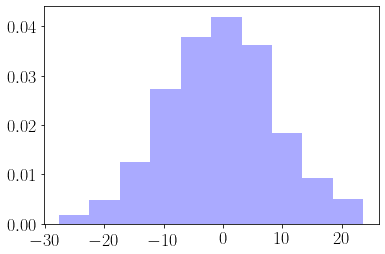

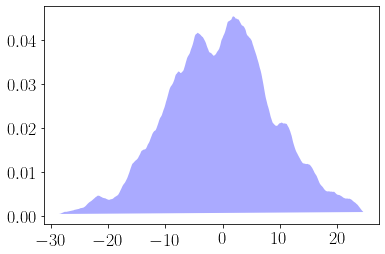

In [4]:
from sklearn.neighbors import KernelDensity

def compute_density(Z,A,show_graphs=False,Z_test=[]):

    bandwidth = np.sqrt(np.median(np.abs(Z)))

    kde_0 = KernelDensity(kernel='linear', bandwidth=bandwidth).fit(Z[A==0][:, np.newaxis])
    kde_1 = KernelDensity(kernel='linear', bandwidth=bandwidth).fit(Z[A==1][:, np.newaxis])
    
    if show_graphs:
        plt.clf()
        plt.hist(Z[A==0], fc='#AAAAFF', density=True)
        plt.show()

        X_plot = np.linspace(min(Z[A==0])-1, max(Z[A==0])+1, 1000)[:, np.newaxis]
        log_dens = kde_0.score_samples(X_plot)

        plt.clf()
        plt.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
        plt.show()

    log_dens_0 = np.exp(np.squeeze(kde_0.score_samples(Z[:, np.newaxis])))
    log_dens_1 = np.exp(np.squeeze(kde_1.score_samples(Z[:, np.newaxis])))
    p_0 = np.sum(A==0) / A.shape[0]
    p_1 = 1 - p_0

    # p(A=1|y) = p(y|A=1)p(A=1) / (p(y|A=1)p(A=1) + p(y|A=0)p(A=0))
    p_success = (log_dens_1*p_1) / (log_dens_1*p_1 + log_dens_0*p_0)

    p_success_test = []
    if len(Z_test) > 0:
        log_dens_0_test = np.exp(np.squeeze(kde_0.score_samples(Y_test[:, np.newaxis])))
        log_dens_1_test = np.exp(np.squeeze(kde_1.score_samples(Y_test[:, np.newaxis])))
        p_success_test = (log_dens_1_test*p_1) / (log_dens_1_test*p_1 + log_dens_0_test*p_0)
    
    return p_success, p_success_test

p_success, p_success_test = compute_density(Y,A,True,Y_test)

Implementation of a fairness-unaware baseline algorithm

In [5]:
bhat, res, rank, s = np.linalg.lstsq(X, Y)

Yhat_out_cal = np.dot(X_cal,bhat)
Yhat_out_test = np.dot(X_test,bhat)

print("Baseline (All): Test Error = " + str(np.sqrt(np.mean((Yhat_out_test - Y_test)**2))))
print("Baseline (A=0): Test Error = " + str(np.sqrt(np.mean((Yhat_out_test[A_test==0] - Y_test[A_test==0])**2))))
print("Baseline (A=1): Test Error = " + str(np.sqrt(np.mean((Yhat_out_test[A_test==1] - Y_test[A_test==1])**2))))

Baseline (All): Test Error = 2.290219544054363
Baseline (A=0): Test Error = 4.961119700322595
Baseline (A=1): Test Error = 1.792217132193679


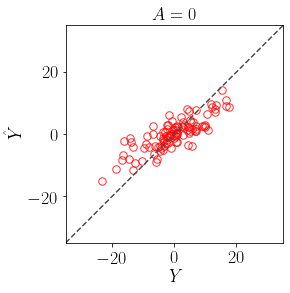

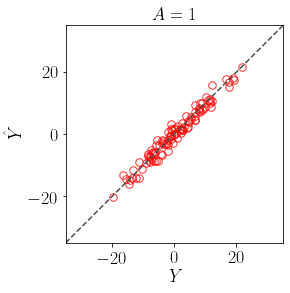

Init Loss = 75.039825
Final Loss = 4.182099
CRT (regression score), avg p-value: 0.000999000999000999


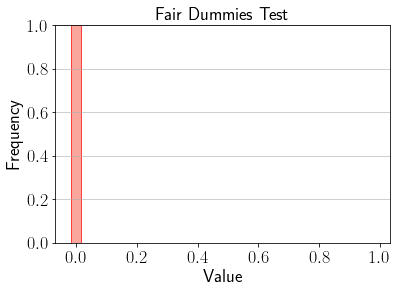

In [6]:
plot_groups_pointwise(x_axis_0_test,
                      x_axis_1_test,
                      A_test,
                      Y_test,
                      Yhat_out_test,
                      y_u=None,
                      y_l=None,
                      point_color='r.',
                      shade=None,
                      filename_0="synth_baseline_0.png",
                      filename_1="synth_baseline_1.png",
                      save_figures=save_figures)

p_val_base = utility_functions.fair_dummies_test_regression(Yhat_out_cal,
                                            A_cal,
                                            Y_cal,
                                            Yhat_out_test,
                                            A_test,
                                            Y_test,
                                            num_reps = 1,
                                            num_p_val_rep=1000,
                                            reg_func_name="Net",
                                            lr = 0.01,
                                            return_vec=True)


plt.clf()
x, bins, p=plt.hist(x=p_val_base, bins=30, color='salmon', alpha=0.7, range=(0, 1), density=True, ec='red', align='left', label=u'Baseline')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Fair Dummies Test')
for item in p:
    item.set_height(item.get_height()/sum(x))
plt.ylim(0, 1)

plt.show()

In [7]:
# step size
lr = 0.01

# inner epochs to fit adversary
dis_steps = 40

# inner epochs to fit loss
loss_steps = 40

batch_size = 6000

# utility loss
cost_pred = torch.nn.MSELoss()
in_shape = X.shape[1]
out_shape = 1

model_type = "linear_model"

# equalized odds penalty
mu = 0.99
second_moment_scaling = 0

# total number of epochs
epochs = 300

In [8]:
fair_reg = fair_dummies_learning.EquiRegLearner(lr=lr,
                                                 pretrain_pred_epochs=0,
                                                 pretrain_dis_epochs=0,
                                                 epochs=epochs,
                                                 loss_steps=loss_steps,
                                                 dis_steps=dis_steps,
                                                 cost_pred=cost_pred,
                                                 in_shape=in_shape,
                                                 batch_size=batch_size,
                                                 model_type=model_type,
                                                 lambda_vec=mu,
                                                 second_moment_scaling=second_moment_scaling,
                                                 out_shape=out_shape)

init_seed(seed)

input_data_train = np.concatenate((A[:,np.newaxis],X),1)
fair_reg.fit(input_data_train, Y)

input_data_cal = np.concatenate((A_cal[:,np.newaxis],X_cal),1)
Yhat_out_cal = fair_reg.predict(input_data_cal)

input_data_test = np.concatenate((A_test[:,np.newaxis],X_test),1)
Yhat_out_test = Yhat_test = fair_reg.predict(input_data_test)

In [9]:
print("Fair Dummies (All): Test Error = " + str(np.sqrt(np.mean((Yhat_out_test - Y_test)**2))))
print("Fair Dummies (A=0): Test Error = " + str(np.sqrt(np.mean((Yhat_out_test[A_test==0] - Y_test[A_test==0])**2))))
print("Fair Dummies (A=1): Test Error = " + str(np.sqrt(np.mean((Yhat_out_test[A_test==1] - Y_test[A_test==1])**2))))

Fair Dummies (All): Test Error = 3.330985387482728
Fair Dummies (A=0): Test Error = 3.077395467686243
Fair Dummies (A=1): Test Error = 3.3564943530387064


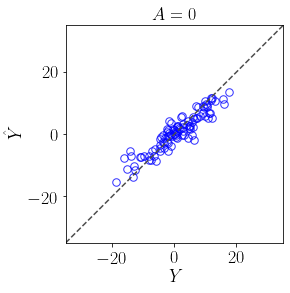

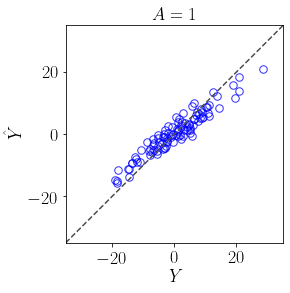

Init Loss = 50.29573
Final Loss = 6.0082054
CRT (regression score), avg p-value: 0.4515484515484515


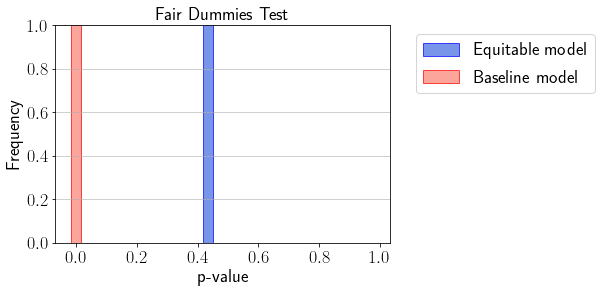

In [10]:
plot_groups_pointwise(x_axis_0_test,
                      x_axis_1_test,
                      A_test,
                      Y_test,
                      Yhat_out_test,
                      y_u=None,
                      y_l=None,
                      point_color='b.',
                      shade=None,
                      filename_0="synth_equi_0.png",
                      filename_1="synth_equi_1.png",
                      save_figures=save_figures)


p_val_equi = utility_functions.fair_dummies_test_regression(Yhat_out_cal,
                                            A_cal,
                                            Y_cal,
                                            Yhat_out_test,
                                            A_test,
                                            Y_test,
                                            num_reps = 1,
                                            num_p_val_rep=1000,
                                            reg_func_name="Net",
                                            lr = 0.01,
                                            return_vec=True)


plt.clf()
x_equi, bins_equi, p_equi=plt.hist(x=p_val_equi, bins=30, color='royalblue', alpha=0.7, range=(0, 1), density=True, ec='blue', align='left', label=u'Equitable model')
x_base, bins_base, p_base=plt.hist(x=p_val_base, bins=30, color='salmon', alpha=0.7, range=(0, 1), density=True, ec='red', align='left', label=u'Baseline model')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Fair Dummies Test')
for item in p_equi:
    item.set_height(item.get_height()/sum(x_equi))
for item in p_base:
    item.set_height(item.get_height()/sum(x_base))

plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 
plt.show()
